<img src="img\Ines_Logo_blau_dt.jpg" width="300"/>

# Diesel Generator Model

The model is based on the article:\
Dufo-López, R., Bernal-Agustín, J. L., Yusta-Loyo, J. M., Domínguez-Navarro, J. A., Ramírez-Rosado, I. J., Lujano, J., & Aso, I. (2011). Multi-objective optimization minimizing cost and life cycle emissions of stand-alone PV–wind–diesel systems with batteries storage. Applied Energy, 88(11), 4033-4041.

##### Model Equations
1. *Output Power*\
$$ P_{out}[t] = n_{dg}[t].P_{nom}.N_{dg}[t] $$\
where $n_{dg}$ is the power factor which the generator is running and $P_{nom}$ the nominal power given in kVA. $N_{dg}$ defines either the generator is running or not (binary variable).

2. *Fuel Consumption*\
$$ F_{cons}[t]= \Big{(}A_{G}.P_{out}[t]+B_{G}.P_{nom}[t]\Big{)}N_{dg}[t]$$\
where $A_{G}$ and $B_{G}$ are coefficients of the consumtion curve, given in $\frac{l}{kWh}$.

3. *Cost*\
$$ Cost_{dg}[t] = \lambda_{fuel}.F_{cons}[t] $$\
where $\lambda_{fuel}$ is the fuel cost (gasoline or diesel) in $\frac{€}{l}$. The following notebook describes the development of the above model.

4. *$CO_{2}$ Emission*
$$E_{rate}[t] = \lambda_{CO_2}.F_{cons}[t]$$\
where $\lambda_{CO_2}$ is the emission coefficient given in $\frac{kgCO_2}{l}$.

##### Model Constraints
* Power factor conform a range defined by the user $n_{min}<n_{dg}<n_{max}$, e.g between 30-90% of rated power.
* Output power is split into power that is used and power that can be sold. These two values are included in the power balance and costs/income of the plant. $P_{out}[t] = P_{dg_{use}}[t]+P_{dg_{sell}}[t]$

### Imports

In [1]:
import sys
import os
from pathlib import Path

sys.path.append(f'{Path(sys.path[0]).parents[1]}')
sys.path.append('../')

In [2]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from SME_LIB.sme import SME

import gurobipy as gb

#MFS Formulation
from cs.opt_formulations_mpc.mfs_opt_formulation import mfs_opt_formulation
from cs.opt_formulations_mpc.mfs_opt_formulation import mfs_opt_formulation_scheduling

#Import MPC Formulation(CAS;PCS:PHS)
from cs.opt_formulations_mpc.cas_formulation import cas_opt_formulation_mpc
from cs.opt_formulations_mpc.phs_formulation import phs_opt_formulation_energy_based_mpc
from cs.opt_formulations_mpc.pcs_formulation import pcs_opt_formulation_mpc
from cs.opt_formulations_mpc.hvac_formulation import hvac_opt_formulation_mpc
from cs.opt_formulations_mpc.es_formulation import es_pv_opt_formulation_mpc
#Battery Formulation
from cs.opt_formulations_mpc.es_formulation import es_bess_opt_formulation_mpc
from cs.opt_formulations_mpc.es_formulation import chp_formulation_mpc

#Import MILP Formulation(CAS;PCS:PHS)
from cs.opt_formulations_milp.cas_formulation import cas_opt_formulation
from cs.opt_formulations_milp.phs_formulation import phs_opt_formulation_energy_based

from cs.opt_formulations_milp.pcs_formulation import pcs_opt_formulation
from cs.opt_formulations_milp.hvac_formulation import hvac_opt_formulation
from cs.opt_formulations_milp.es_formulation import es_pv_opt_formulation
#CHP Formulation
from cs.opt_formulations_milp.es_formulation import chp_formulation
#DG Formulation
from cs.opt_formulations_milp.es_formulation import es_dg_opt_formulation
#Battery Formulation
from cs.opt_formulations_milp.es_formulation import es_bess_opt_formulation

#Import the functions for appending the results
from cs.append_results.append_results import mfs_opt_results
from cs.append_results.append_results import cas_opt_results
from cs.append_results.append_results import pcs_opt_results
from cs.append_results.append_results import phs_opt_results
from cs.append_results.append_results import es_bess_opt_results
from cs.append_results.append_results import es_chp_opt_results
from cs.append_results.append_results import hvac_opt_results
from cs.append_results.append_results import es_pv_results

[]


In [3]:
# Setting figure size for charts.
plt.rcParams['figure.figsize'] = [14, 5]

### Create SME

In [4]:
# Create the SME Object
steel_plant=SME(id="kw_lahr", name="Kunstoff Werk Lahr",ort="Lahr")

# Create MFS 
path = str(Path(sys.path[0]).parents[0])
steel_plant.create_mfs(id="MFS",desc="This is the manufacturing systems of Steel_Plant")
steel_plant.mfs.create_mfs_from_file(file_path=path+'\modelled_smes\steel_plant\model_inputs\mfs.xlsx')

# Calculate tasks
# steel_plant.mfs.calculate_task_validity_interval()

### Create TBS System

In [5]:
### Create TBS System ###
steel_plant.create_tbs(id="KW_LAHR_TBS",desc="This is the TBS object of the SME")

#Create the commpressed air system (CAS) inside the TBS
steel_plant.tbs.create_cas(id="CAS",desc="This is the CAS System of KW Lahr")
#Create the compressors
steel_plant.tbs.cas.create_compressor(id="K1", p_kw=11, pressure_max=8, m3_per_min=2.57,usage_number=2,control="Continuous",t_on=2,t_off=2)
steel_plant.tbs.cas.create_compressor(id="K2", p_kw=30, pressure_max=8, m3_per_min=5.31,usage_number=2,control="Binary",t_on=2,t_off=2)
steel_plant.tbs.cas.create_storage_tank(id="S_air",capacity=500,soc_initial=0.25,soc_max=0.99,soc_min=0.01,pressure_max=10,p_set=8,pressure_min=7)

#Create the PCS System
steel_plant.tbs.creat_pcs(id="PCS",desc="This is the PCS System")
#Create the chillers
steel_plant.tbs.pcs.create_chiller(id="Chiller-01",p_kw=18,cooling_capacity=50,cop=2.67,mass_flow_rate=0.00155,temp_supply=21,temp_return=26, t_on=2,t_off=2,control="Binary")

#Create the water storage tank
steel_plant.tbs.pcs.create_storage_tank(id='s_cws',volume=5,temp_set=20,temp_max=24,temp_min=16)

#Create the PHS Systems
steel_plant.tbs.create_phs(id="PHS",desc="This is PHS System")
steel_plant.tbs.phs.create_heat_pump(id="HP-1",p_kw=20,cop=1,control="Continous",t_on=2,t_off=2)
steel_plant.tbs.phs.create_heat_pump(id="HP-2",p_kw=10,cop=1,control="Binary",t_on=2,t_off=2)
steel_plant.tbs.phs.create_phs_storage_tank(id="S_PHS",volume=5,k_v=0.00534,temp_set=37,temp_max=80,temp_min=35)

#Create the HVAC System
steel_plant.tbs.create_hvac(id="HVAC",desc="This is a HVAC System of the KMU",space_area=500,heat_loss_coeff=0.3,thermal_capacity=16500,t_set_min=19.5,t_set=20,t_set_max=20.5)

### Create Energy System

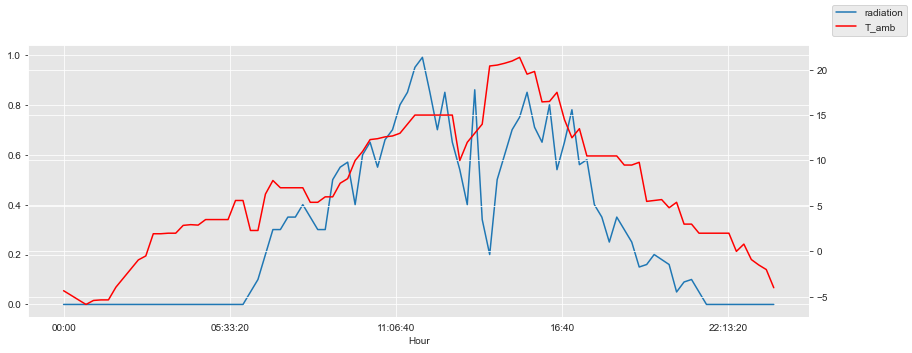

In [6]:
### Create Energy System ###
steel_plant.create_es(id="KW_LAHR_ES",desc="This is the ES Object of the SME")

# Loading Profiles for HVAC and PV
df_aux = pd.read_excel(path+'\modelled_smes\steel_plant\model_inputs\pv_radiation.xlsx')

ax = df_aux.plot(x="Hour", y="radiation", legend=False)
ax2 = ax.twinx()
df_aux.plot(x="Hour", y="T_amb", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

steel_plant.tbs.hvac.t_amb = list(df_aux["T_amb"])
steel_plant.es.pv_radiation_data = list(df_aux["radiation"])

#Create the PV plants
steel_plant.es.create_pv(id="PV_1",p_rated=50)
steel_plant.es.create_pv(id="PV_2", p_rated=50)

#Create the ESS
steel_plant.es.create_ess(id="Batt_1", kwh_max=300, initial_soc=0.2, charging_rate_max=75, charge_efficiency=1,
                     soc_min=0.1,soc_max=0.8,discharge_rate_max=75, discharge_efficiency=1)

#Create the CHP Plant
steel_plant.es.create_chp(id='CHP_1',f_nom=20.5,p_nom=5.5,q_nom=12.5,n_heat=0.9,n_ele=0.9,fuel_cost=0.05,storage_capacity=75,
                      storage_capacity_max=0.95,storage_capacity_min=0.35,soc_ini =0.01, t_on=45,t_off=30,chp_on_past=[0,0,1],
                      n_switches=50,storage_loss_factor=0.0534)


### Diesel Generator Class

A subclass called DG (Diesel generator) was included inside the ES class (energy system) with the following structure and paramenters.
<font size="2">
```python
    class DG:
        def __init__(self, id, p_rated, cons_a, cons_b, price_fuel, n_min, n_max, e_max, e_coef ):
            self.id =id
            self.p_rated=p_rated # rated power kW
            self.cons_a=cons_a # consumption curve coefficient l/kW.h
            self.cons_b=cons_b # consumption curve coefficient l/kW.h
            self.price_fuel = price_fuel # $/l
            self.n_min = n_min # min power factor
            self.n_max=n_max # max power factor
            #self.e_max = e_max # limit of emission rate kgCO2/h
            self.e_coef = e_coef # emission rate coeficient kgCO2/kWh
```
</font>

and also a function that creates the DG. Shown below:\
<font size="2">
```python
    def create_dg(self, id, p_rated, cons_a, cons_b, price_fuel, n_min, n_max, e_max, e_coef ):
        self.dg[id]=(self.DG(id=id,p_rated=p_rated, cons_a=cons_a, cons_b=cons_b, price_fuel=price_fuel, n_min=n_min, n_max=n_max, e_max=e_max, e_coef=e_coef)).__dict__
```
</font>

In [7]:
# Create Diesel Generator

# parameters
p_rated = 20 # rated power in kvA
cons_a = 0.246 # l/kWh
cons_b = 0.08145 # l/kWh
price_fuel = 0.01 # eur/l
n_min = 0.3 # 30% of rated power
n_max = 0.9 # 100% of rated power
e_coef = 3.5 # kgCO2 per kVA
# e_max = 100 # try to find in the literature
id="DG-1"

steel_plant.es.create_dg(id, p_rated,cons_a,cons_b, price_fuel, n_min, n_max, e_coef)


### Diesel Generator Formulation
Based on the model shown in the beginning. We formulate the DG using the Gurobi built-in functions, creating the variables and setting the constraints, as follows:
<font size="2">
```python
    def es_dg_opt_formulation(self, mdl, K):

        # Collecting parameters
        n_min = self.es.dg["DG-1"]["n_min"]
        n_max = self.es.dg["DG-1"]["n_max"]
        # e_max = self.es.dg["DG-1"]["e_max"]
        p_rated = self.es.dg["DG-1"]["p_rated"]
        cons_a = self.es.dg["DG-1"]["cons_a"]
        cons_b = self.es.dg["DG-1"]["cons_b"]
        e_coef = self.es.dg["DG-1"]["e_coef"]
        price_fuel = self.es.dg["DG-1"]["price_fuel"]

        # Add Diesel Generator variables
        p_dg_out = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,lb=n_min*float(p_rated),ub=n_max*float(p_rated),name="p_dg_out")
        fuel_cons_dg = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="fuel_cons_dg")
        e_dg_rate = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="e_dg_rate")
        n_dg_gen = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,lb=n_min,ub=n_max,name="n_dg_gen")
        N_dg = mdl.addVars(len(K),vtype=GRB.BINARY, name="N_dg")
        p_dg_use = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="p_dg_use")
        p_dg_sold = mdl.addVars(len(K),vtype=GRB.CONTINUOUS, name="p_dg_sold")
        p_dg_cost = mdl.addVars(len(K),vtype=GRB.CONTINUOUS, name="p_dg_cost")

        # Add Constraints
        mdl.addConstrs(p_dg_out[t] == n_dg_gen[t]*p_rated*N_dg[t] for t in K)
        mdl.addConstrs(fuel_cons_dg[t] == (cons_a*p_dg_out[t]+cons_b*p_rated)*N_dg[t] for t in K)
        mdl.addConstrs(e_dg_rate[t] == e_coef*fuel_cons_dg[t] for t in K)
        mdl.addConstrs(p_dg_cost[t] == price_fuel*fuel_cons_dg[t] for t in K)
        mdl.addConstrs(p_dg_out[t] == p_dg_use[t]+p_dg_sold[t] for t in K)

        return p_dg_out, fuel_cons_dg, e_dg_rate,n_dg_gen, p_dg_sold, p_dg_use, p_dg_cost, N_dg
```
</font>

# CONTROL SYSTEM

In [8]:
self = steel_plant

# Create the Optimization model Framework
mdl = gb.Model("DG_Opt")

# Number of time steps
t_hr = [t for t in self.hr]  # time step in hr
T = self.N_sim  # time step in 0,1,2,3,..
K = T


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-07-10
Using license file C:\Users\guilh\gurobi.lic


### Create Market

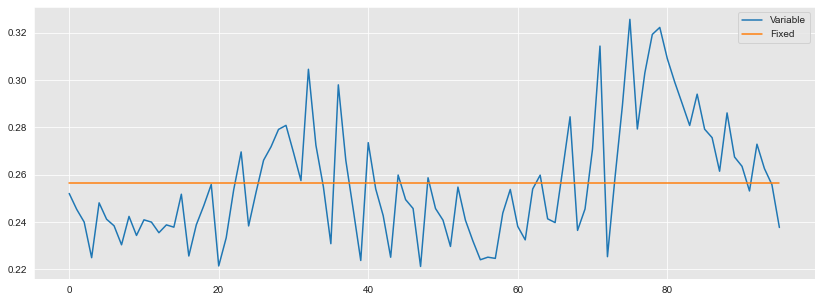

In [9]:
#Create the market of the SME
market = steel_plant.create_market(id="M-01",type="Fixed",desc="Fixed Price",price_buy=3,price_sell=2,
                         electiricity_tax=2.05,demand_rate=141.62,energy_rate=0.45,eeg_surcharge=6.5,kwk_surcharge=5,
                         offshore_surcharge=0.049,abschalt_surcharge=0.011,tax=19,pltw=[24,36],retailer_cut_da=10)

# Get day ahead prices
prices_original = pd.read_excel(path+'\modelled_smes\steel_plant\model_inputs\market_price.xlsx')
prices = (prices_original["price"]/1000).to_list()
steel_plant.day_ahead_prices = prices

# Get market information
market = steel_plant.markets["M-01"]
participation_mechanism = "Day_ahead"

p_fix = (market.electiricity_tax + market.eeg_surcharge + market.abschalt_surcharge + market.kwk_surcharge + market.kwk_surcharge)/100
tax = market.tax/100

market.prices_variable["Price"] = [(x+p_fix)*(1+tax) for x in steel_plant.day_ahead_prices]
market.prices_fixed["Price"] = [(market.price_buy/100+p_fix)*(1+tax)]*len(K)

ax= market.prices_variable["Price"].plot(label="Variable")
ax2=market.prices_fixed["Price"].plot(label="Fixed")
plt.legend()


### Call Formulations

In [10]:
self = steel_plant

# Call the MFS Optimization System
p_mfs_t,air_demand_t,q_cool_demand_t,q_heat_demand_t,tasks,machines,products,storages,p_r_t,N_i_t,Y_i_t,R_i_t,S_i_t,R_r_t,R_s_t = \
    mfs_opt_formulation(self=self,mdl=mdl,T=K)

# Call the CAS System Optimization
p_cas_t, Pel_k, v_out, v_in, v_stor_t, p_t, N_k_t, compressors = cas_opt_formulation(self=self, mdl=mdl,
                                                                                                 K=K,
                                                                                                 mode="MILP", x_o={},
                                                                                                 from_agent=False,
                                                                                                 air_demand_opt=air_demand_t)

# Call the HVAC Optimization
T_r, T_amb, Qc_hvac, Qh_hvac = hvac_opt_formulation(self=self, mode="MILP", mdl=mdl, x_o={}, K=K)

# Call the PCS System Optimization
p_pcs_t, Pel_c, Ts_pcs, q_tes_t, qc_in_t, qc_out_t, chillers, N_c_t, delta_t = \
    pcs_opt_formulation(self=self,mdl=mdl,K=K, mode="MILP",x_o={}, from_agent=False ,cooling_demand_t=q_cool_demand_t,Qc_hvac=Qc_hvac)

# Call CHP Formulation
q_chp_in, p_chp_use, p_chp_sold, chp_cost, chp_on, chp_off = chp_formulation(self=self, mdl=mdl, K=K, x_o={}, mode="MILP", chp_on_past=[0, 0, 1])

# Call the PHS System Optimization
N_h_t,p_phs_t, Pel_h, H_test_t, T_phs_t, Qh_in_t, Qmfs_out_t, Qchp_in_t = \
                phs_opt_formulation_energy_based(self=self, mdl=mdl, K=K, x_o={}, from_agent=False,
                                                 heating_demand_t=q_heat_demand_t,
                                                 q_chp_in=q_chp_in, Qh_hvac=Qh_hvac, mode="MILP", hvac_opt=True)

#Battery Energy Systems
p_batt_ch, p_batt_disch, p_batt_use, p_batt_sold, E_batt, y_batt = es_bess_opt_formulation(self=self, mdl=mdl,
                                                                                                   K=K,
                                                                                                   mode="MILP", x_o={})

# PV Formulation
pv_prod, p_pv_use, p_pv_sold = es_pv_opt_formulation(self=self, mdl=mdl, K=K, mode="MILP")

# DG Formulation
p_dg_out, fuel_cons_dg, e_dg_rate,n_dg_gen, p_dg_sold, p_dg_use, p_dg_cost, N_dg = es_dg_opt_formulation(self=self,mdl=mdl, K=K)


In [11]:
L1=1000
L2=0

# %% Grid Variables
p_grid = mdl.addVars(len(K), vtype=gb.GRB.CONTINUOUS, lb=0, ub=L1, name="p_grid")
p_grid_sold = mdl.addVars(K, vtype=gb.GRB.CONTINUOUS, lb=0, ub=L2, name="p_sold")
y_grid = mdl.addVars(len(K), vtype=gb.GRB.BINARY, name="y_grid")

In [12]:
#%% SME Load Demand
demand_kw = mdl.addVars(len(K), vtype=gb.GRB.CONTINUOUS, name="demand_kw")

#Energy/Power Management
mdl.addConstrs(demand_kw[t] == p_cas_t[t] + p_mfs_t[t] + p_pcs_t[t] for t in K)

#Power Balance
mdl.addConstrs(p_grid[t] + p_batt_use[t] + p_pv_use[t] + p_chp_use[t] + p_dg_use[t] == demand_kw[t] + p_batt_ch[t] for t in K) # added the diesel generator output to the power balance

#Total power injected into the Grid
mdl.addConstrs(p_grid_sold[t] == p_batt_sold[t] + p_pv_sold[t] + p_chp_sold[t] + p_dg_sold[t] for t in K)
# Power transaction constraints
mdl.addConstrs(p_grid[t] <= L1 * (y_grid[t]) for t in K)
mdl.addConstrs(p_grid_sold[t] <= L2 * (1 - y_grid[t]) for t in K)
print("")

### Objective Function

In [13]:
c_buy = 0.3
c_sell = 0.3
time_step = self.sim_time_step/60
method = "Multiple Objective  km"
# Objective function
# mdl.setObjective(gb.quicksum(p_grid[t]*(c_buy)*(time_step)  for t in K),gb.GRB.MINIMIZE)

if method == "Multiple Objective":
    # Cost objective function
    mdl.setObjectiveN(gb.quicksum(p_grid[t]*(prices[t])*time_step - p_grid_sold[t]*c_sell*time_step for t in K) \
                     + gb.quicksum(chp_cost[t] for t in K) + gb.quicksum(p_dg_cost[t] for t in K),0,1)
    # CO2 emission objective function
    mdl.setObjectiveN(gb.quicksum(e_dg_rate[t] for t in K),1,0)
    # Set optimization sense to Minimize
    mdl.ModelSense = gb.GRB.MINIMIZE
else:
    mdl.setObjective(gb.quicksum(p_grid[t]*(prices[t])*time_step - p_grid_sold[t]*c_sell*time_step for t in K) \
                     + gb.quicksum(chp_cost[t] for t in K) + gb.quicksum(p_dg_cost[t] for t in K),gb.GRB.MINIMIZE)

In [14]:
mdl.setParam("MIPGap",1)
# mdl.setParam(gb.GRB.Param.TimeLimit, 300.0)

mdl.optimize()

Changed value of parameter MIPGap to 1.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18987 rows, 17666 columns and 47473 nonzeros
Model fingerprint: 0xd1ce71e6
Model has 192 quadratic constraints
Variable types: 9792 continuous, 7874 integer (6914 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  QMatrix range    [2e-01, 2e+01]
  QLMatrix range   [1e+00, 2e+00]
  Objective range  [6e-05, 1e+00]
  Bounds range     [3e-01, 1e+05]
  RHS range        [8e-03, 3e+03]
Presolve removed 13803 rows and 11533 columns
Presolve time: 0.17s
Presolved: 5568 rows, 6229 columns, 22576 nonzeros
Variable types: 1691 continuous, 4538 integer (3802 binary)

Root relaxation: objective 4.500731e+01, 5813 iterations, 0.70 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

# RESULTS

In [15]:
def plot_results(results,size=[14, 7]):
    
    results.index = pd.date_range("00:00","23:45",freq="15min")
    results.index = results.index.time
    results.index.name = "time"
    pd.plotting.register_matplotlib_converters()
    prices = market.prices_variable["Price"]
    prices.index = pd.date_range("00:00","23:45",freq="15min")
    prices.index = prices.index.time
    
    fig, ax = plt.subplots(len(results.columns)+1,sharex=True)
    plt.rcParams['figure.figsize'] = size
    
    for i in range(len(results.columns)+1):
        if i==len(results.columns):
            ax[i] = prices.plot(color="red")
            ax[i].set_ylabel("Price")
        else:
            ax[i].plot(results.index,results[f"{results.columns[i]}"])
            ax[i].set_ylabel(f"{results.columns[i]}")
            ax[i].set_xlabel("")


### Battery

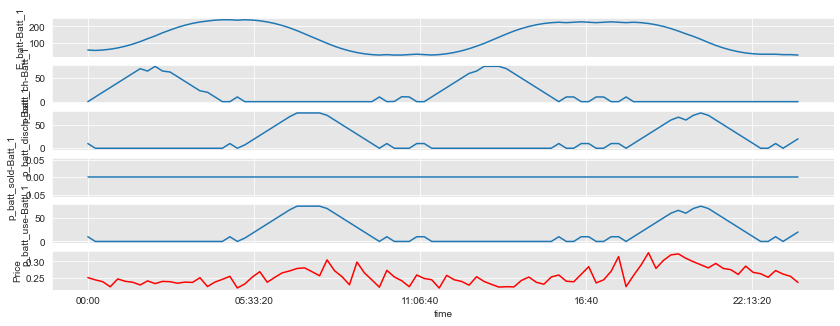

In [16]:
# Battery
es_bess_opt_results(self,K,E_batt,p_batt_ch,p_batt_disch,p_batt_sold,p_batt_use,n=0)
df = pd.DataFrame.from_dict(self.es.ess["Batt_1"]["res_df"])
plot_results(df)

### Combined Heat and Power

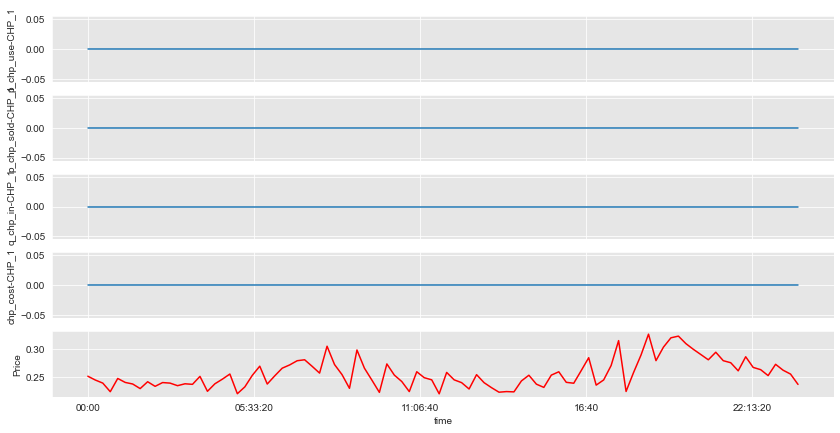

In [17]:
# Battery Energy Storage System (BESS) 
es_chp_opt_results(self,K,p_chp_use,p_chp_sold,q_chp_in,chp_cost)
df = pd.DataFrame.from_dict(self.es.chp["CHP_1"]["res_df"])
plot_results(df)

In [18]:
print(list(self.es.pv_plants.keys()))

['PV_1', 'PV_2']


### Photovoltaic System

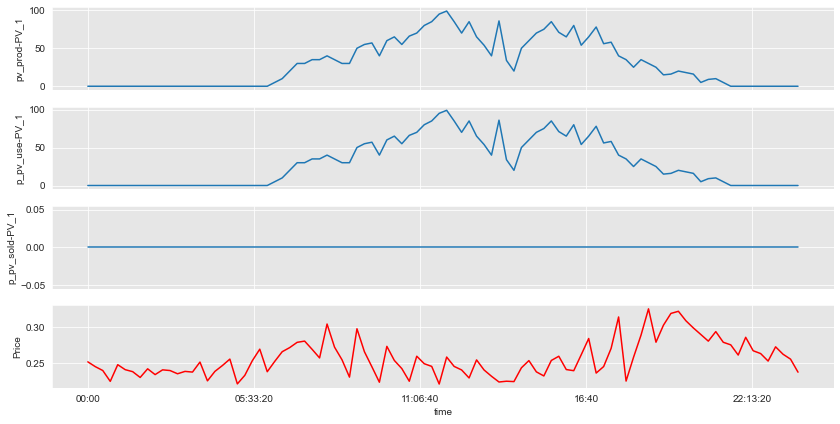

In [19]:
es_pv_results(self,K,pv_prod,p_pv_use,p_pv_sold)
df = pd.DataFrame.from_dict(self.es.pv_plants["PV_1"]["res_df"])
plot_results(df)

### Diesel Generator

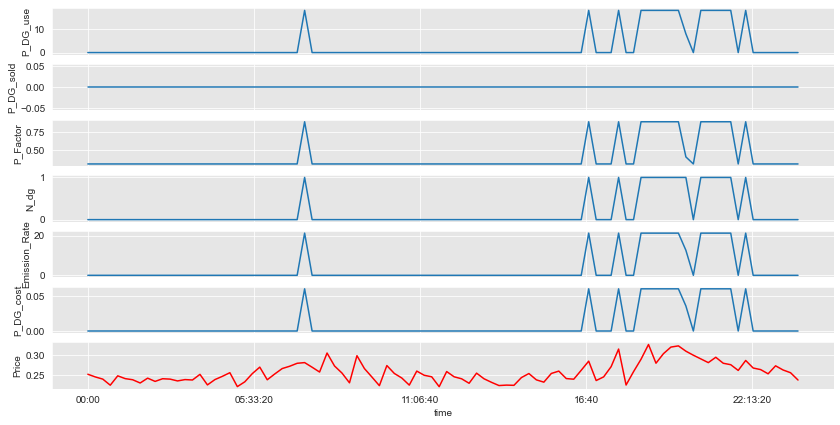

In [20]:
df = pd.DataFrame(columns=["P_DG_use","P_DG_sold","P_Factor","N_dg","Emission_Rate","P_DG_cost",])
df["P_DG_use"] = [p_dg_use[t].x for t in K]
df["P_DG_sold"] = [p_dg_sold[t].x for t in K]
df["P_Factor"] = [n_dg_gen[t].x for t in K]
df["N_dg"] = [N_dg[t].x for t in K]
df["Emission_Rate"] = [e_dg_rate[t].x for t in K]
df["P_DG_cost"] = [p_dg_cost[t].x for t in K]

plot_results(df,size=[15,10])

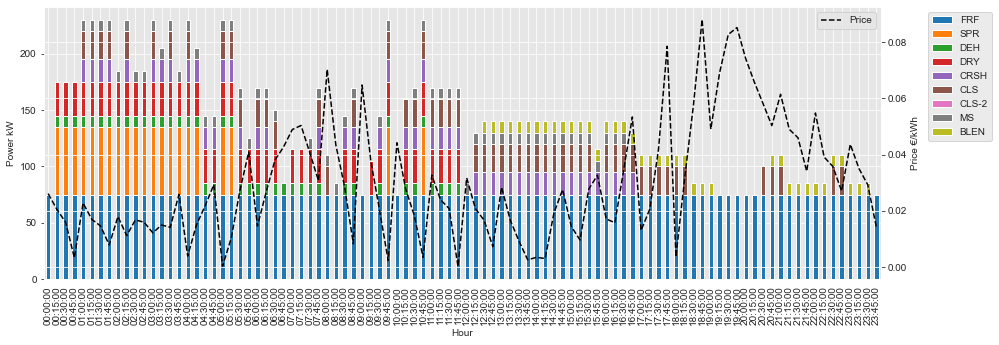

In [21]:
machines_run_fix = pd.DataFrame(columns=[])
for m in machines:
    machines_run_fix[m]  = [p_r_t[m,t].x for t in K]

prices = pd.DataFrame(prices,columns=['Price'])
machines_run_fix = machines_run_fix.set_index(prices_original['Hour'])


plt.rcParams['figure.figsize'] = [15,5]
ax = machines_run_fix.plot.bar(stacked=True,legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2=ax.twinx()
prices.plot(ax=ax2,linestyle='--',color='black')

ax.set_xlabel('Hour')
ax.set_ylabel('Power kW')
ax2.set_ylabel('Price €/kWh')


plt.show()